### Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#! ls ml_wrappers/codes/ 

In [3]:
#! ln -s ../msan/fastai/fastai/fastai .

In [138]:
from fastai.imports import *
from sklearn.model_selection import GridSearchCV
from rfpimp import *
from sklearn.metrics import roc_auc_score
from fastai.structured import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# from ml_wrappers.codes.imports import *
# from ml_wrappers.codes.structured_helper import *

### Functions

In [5]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def convert_cats(train, col_not_convert=[], test=None):
    """
    Convert columns in a training and test dataframe
    into category codes 

    train: Training dataframe
    col_not_convert: list of columns which are string type and which you don't want to convert
    test: Test/ Validation set (Mapping from category codes from training)
    """

    for n, c in train.items():
        if is_string_dtype(c) and n not in col_not_convert:
            train[n] = c.astype('category').cat.as_ordered()

    if test is not None:
        for n, c in test.items():
            if (n in train.columns) and (train[n].dtype.name == 'category'):
                test[n] = pd.Categorical(
                    c, categories=train[n].cat.categories, ordered=True)

    cols = list(train.columns[train.dtypes == 'category'])
    for c in cols:
        train[c] = train[c].astype('category').cat.codes
        if test is not None:
            test[c] = test[c].astype('category').cat.codes

In [6]:
def explore_df(df, classifier=False, target=None):
    print("Name of columns in dataframe : ", df.columns, '\n')
    print('Shape of dataframe : ', df.shape, '\n')
    print('Data types of dataframe : ', '\n', df.dtypes, '\n')
    print("Number of unique values in each column : ", '\n', df.nunique(), '\n')
    print('First 2 rows : \n', df[:2], '\n')
    print('Sum of NAs in each column : \n', df.isna().sum())
    if classifier:
        print("Distribution of labels : \n", df[target].value_counts())

In [140]:
def importances_perm(model, X_valid, y_valid, n_samples=3500):

    if n_samples<0: n_samples = len(X_valid)
    n_samples = min(n_samples, len(X_valid))
    if n_samples<len(X_valid):
        ix = np.random.choice(len(X_valid),n_samples)
        X_valid = X_valid.iloc[ix].copy(deep=False) # shallow copy
        y_valid = y_valid.iloc[ix].copy(deep=False)
    else:
        X_valid = X_valid.copy(deep=False) # we're modifying columns

    baseline = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
    imp = []
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        m = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
        X_valid[col] = save
        imp.append(baseline - m)

    I = pd.DataFrame(data={'Feature': X_valid.columns, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [7]:
def target_encoder_regularized(train, test, cols_encode, y_col, target_cols, folds = 5, stratified=True):
    """
    Mean regularized target encoding based on kfold   
    """
    
    if stratified:
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
        X = train.drop(y_col, axis=1)
        Y = train[y_col]
        splitter = skf.split(X, Y)
    else:
        kf = KFold(n_splits=folds, shuffle=True, random_state=1)
        splitter = kf.split(X)
    
    train_new = pd.DataFrame()
    for train_index, val_index in splitter:
        train_fold = train.loc[train_index]
        test_fold = train.loc[val_index]

        for by in cols_encode:
            for target in target_cols:

                encoding = train_fold.groupby(by)[target].mean()
                test_fold[target + '_mean_' + by] = test_fold[by].map(encoding)

                impute = np.mean(train_fold[target])
                test_fold.fillna(impute, inplace=True)
        train_new = pd.concat((train_new, test_fold), axis=0)
    
    # making test encoding using full training data  
    test_new = test.copy()
    for by in cols_encode:
        for target in target_cols:
            test_new['%s_mean_%s' % (target, by)] = test_new[by].map(train_new.reset_index(drop=True).groupby(by)[target].mean())

    return train_new.reset_index(drop=True), test_new.reset_index(drop=True)

#     # set_trace()
#     test_copy = test.copy()
#     train_copy = train.copy()
    
#     for col in cols_encode:       
#         train_copy['%s_mean_reg_%s' % (target, col)] = np.zeros(len(train_copy))
#         test_copy['%s_mean_reg_%s' % (target, col)] = np.zeros(len(test_copy))
        
#         for train_index, val_index in splitter:
            
#             mean_target = train_copy.loc[train_index, col].map(
#             train_copy.iloc[train_index,:].groupby(col)[target].mean())

#             train_copy.loc[val_index,'%s_mean_reg_%s' % (target, col)] = train_copy.loc[val_index, col].map(mean_target)
            
#         global_mean = train_copy[target].mean()
#         train_copy['%s_mean_reg_%s' % (target, col)].fillna(global_mean, inplace=True)
        
#     # making test encoding using full training data    
#     test_copy['%s_mean_reg_%s' % (target, col)] = test_copy[col].map(train_copy.groupby(col)[target].mean())
            
#     return train_copy, test_copy

### Data preparation

#### Initial Exploration
Check df shape, columns, class imbalance, dtypes 

In [8]:
sample = pd.read_csv('sample_submission_1.csv')

In [9]:
sample[:2]

,id,stroke
0,36306,0
1,61829,0


In [10]:
train = pd.read_csv('train_ajEneEa.csv')
test = pd.read_csv('test_v2akXPA.csv')

In [11]:
train.shape, test.shape

((43400, 12), (18601, 11))

In [12]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [13]:
test.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,18601.000000,18601.000000,18601.000000,18601.000000,18601.000000,18010.000000
mean,36747.368045,42.056504,0.093167,0.048062,104.386359,28.545325
std,21053.151124,22.528018,0.290674,0.213903,42.606714,7.757092
min,2.000000,0.080000,0.000000,0.000000,55.000000,10.200000
25%,18542.000000,24.000000,0.000000,0.000000,77.550000,23.300000
50%,36717.000000,43.000000,0.000000,0.000000,91.830000,27.700000
75%,55114.000000,60.000000,0.000000,0.000000,112.310000,32.800000
max,72942.000000,82.000000,1.000000,1.000000,275.720000,88.300000


In [14]:
# def mean_min_max(df):
#     for col in df.columns:
#         if df[col].dtype == int or df[col].dtype == float:
#             print(col)
#             print("Mean : ", np.mean(df[col], axis=0), ' | ' 
#                   "Min : ", np.min(df[col], axis=0), ' | '
#                   'Max : ', np.max(df[col],axis=0), '\n')

In [15]:
#mean_min_max(train)

In [16]:
#mean_min_max(test)

In [17]:
explore_df(train)

Name of columns in dataframe :  Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object') 

Shape of dataframe :  (43400, 12) 

Data types of dataframe :  
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object 

Number of unique values in each column :  
 id                   43400
gender                   3
age                    104
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level    12543
bmi                    555
smoking_status      

In [18]:
explore_df(test)

Name of columns in dataframe :  Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object') 

Shape of dataframe :  (18601, 11) 

Data types of dataframe :  
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object 

Number of unique values in each column :  
 id                   18601
gender                   3
age                    104
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level     8744
bmi                    500
smoking_status           3
dtype: int64 

First 2 rows : 
 

**Data imbalance or not?**

In [19]:
train.stroke.value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [20]:
np.round(sum(train.stroke == 1)/train.shape[0]*100, 2)

1.8

#### Secondary Preparation
Coverting categorical columns to labels, replace NAs with particular value


**Converting to cat codes. It will also fillna with -1 for string columns**

In [21]:
convert_cats(train, test = test)

In [22]:
train[:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,0,4,0,95.12,18.0,-1,0
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0


In [23]:
test[:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,1,80.0,0,0,1,2,1,83.84,21.1,0
1,61829,0,74.0,0,1,1,3,0,179.50,26.0,0


** FIlling NAs for bmi **

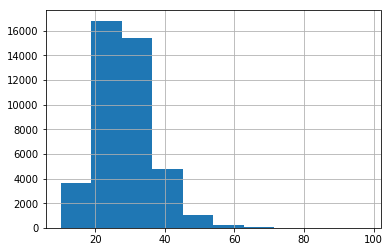

In [24]:
train.bmi.hist()

In [25]:
train_mean = train.bmi.mean()
train.bmi.fillna(train_mean, inplace=True)
test.bmi.fillna(train_mean, inplace=True)

### Distribution plots

In [26]:
def density_plot(df):
    ''' Explore data by plotting KDE graphs. '''
    
    
    #Define figure subplots
    fig = plt.figure(1, figsize=(25,10))
   # fig, ax = plt.subplots(nrows=3)
    
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    #Loop through features    
    i = 1
    for col in df.columns:
        
        #Set subplot and plot format        
        sns.set_style("ticks")
        sns.set_context("paper", font_scale = 3, rc={"lines.linewidth": 1})
        plt.subplot(8,2,0 + i)
        j = i - 1
        
        #Plot KDE for all labels
        sns.distplot(df[df['stroke'] == 0].iloc[:,j], hist = False, label = 'no stroke', kde_kws={"lw":4})
        sns.distplot(df[df['stroke'] == 1].iloc[:,j], hist = False, label = 'stroke', kde_kws={"lw":4})
        plt.legend();
        i = i + 1
    
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()

/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


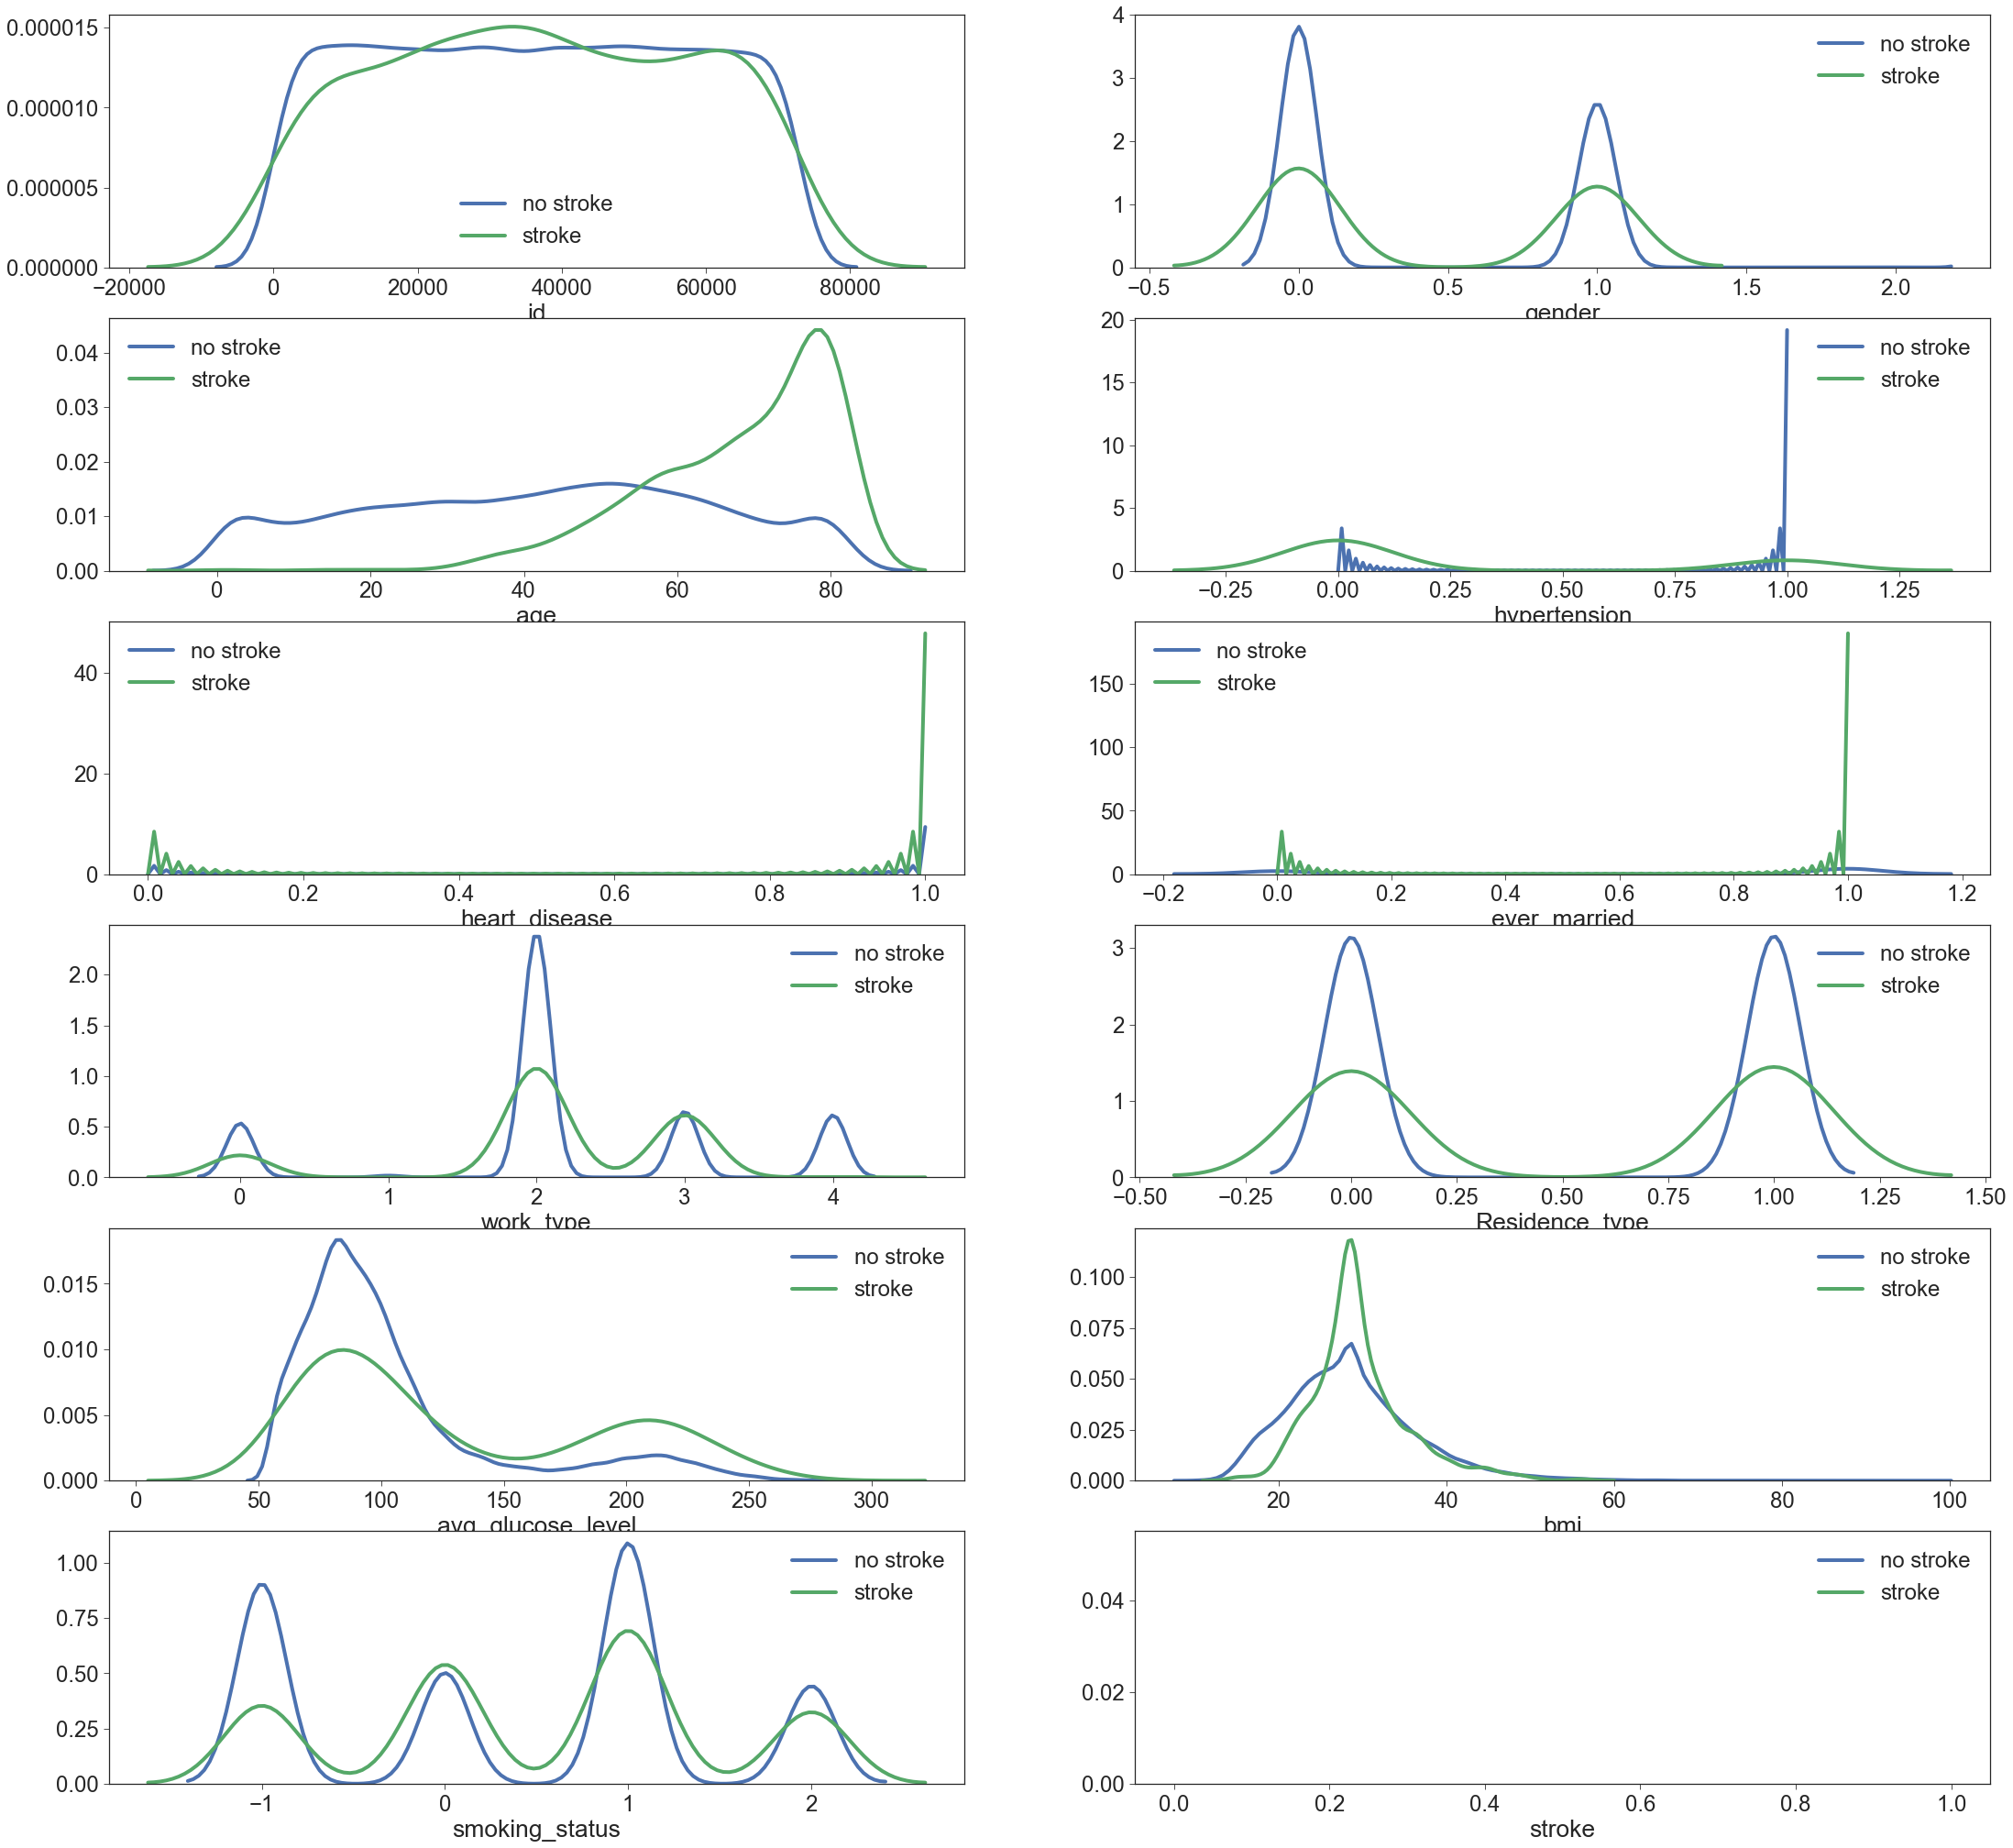

In [112]:
density_plot(train)

In [114]:
x.Residence_type.value_counts()

1    21756
0    21644
Name: Residence_type, dtype: int64

Features with little or more shift in distributions:

* Heart Disease
* Age (after binning)
* smoking_status
* Gender
* Residence Type
* Ever Married
* Work Type

### Modelling

In [32]:
train[:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,0,4,0,95.12,18.0,-1,0
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0


In [33]:
x = train.drop(labels='stroke', axis=1)
y = train['stroke']

#### Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

Grid search

In [50]:
# predictons = m.predict_proba(test)[:,1]
# pred_df = pd.DataFrame(test.id)
# pred_df['stroke'] = predictons

In [60]:
# pred_df[:1]

,id,stroke
0,36306,0.723278


In [64]:
# pred_df.to_csv('submissions/rf_baseline.csv', index=False)

### Age binning

In [27]:
train2 = train.assign(age_bins =  pd.cut(train.age, 4, retbins=False, include_lowest=True))

In [28]:
test2 = test.assign(age_bins =  pd.cut(test.age, [-0.00192, 20.56, 41.04, 61.52, 82.],
                                       retbins=False, include_lowest=True))

In [29]:
train2.age_bins = train2.age_bins.cat.codes
test2.age_bins = test2.age_bins.cat.codes

In [209]:
train2.to_csv('intermediate_data/raw_train.csv', index=False)
test2.to_csv('intermediate_data/raw_test.csv', index=False)

### Target Encoding

In [118]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [82]:
train_enc, test_enc = target_encoder_regularized(train2, test2, 
                                                 ['gender', 'hypertension', 
                                                  'smoking_status', 'heart_disease', 
                                                  'Residence_type', 'ever_married',
                                                  'age_bins'],
                                                 
                                                 'stroke',
                                                 
                                                 ['avg_glucose_level',
                                                  'stroke', 
                                                  'bmi' ],
                                                 folds = 5)

In [83]:
test_enc[:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,bmi_mean_heart_disease,avg_glucose_level_mean_Residence_type,stroke_mean_Residence_type,bmi_mean_Residence_type,avg_glucose_level_mean_ever_married,stroke_mean_ever_married,bmi_mean_ever_married,avg_glucose_level_mean_age_bins,stroke_mean_age_bins,bmi_mean_age_bins
0,36306,1,80.0,0,0,1,2,1,83.84,21.1,...,28.512695,104.483331,0.018340,28.576962,109.409233,0.025163,30.522851,120.376405,0.057177,29.80115
1,61829,0,74.0,0,1,1,3,0,179.50,26.0,...,30.456295,104.482166,0.017742,28.633260,109.409233,0.025163,30.522851,120.376405,0.057177,29.80115


In [84]:
train_enc[:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,bmi_mean_heart_disease,avg_glucose_level_mean_Residence_type,stroke_mean_Residence_type,bmi_mean_Residence_type,avg_glucose_level_mean_ever_married,stroke_mean_ever_married,bmi_mean_ever_married,avg_glucose_level_mean_age_bins,stroke_mean_age_bins,bmi_mean_age_bins
0,56543,0,70.0,0,0,1,2,0,69.04,35.9,...,28.492446,104.32487,0.017737,28.623752,109.177633,0.025117,30.500906,120.176821,0.057451,29.781914
1,15266,0,32.0,0,0,1,2,0,77.67,32.3,...,28.492446,104.32487,0.017737,28.623752,109.177633,0.025117,30.500906,96.573910,0.002422,29.757469


### Validation split

In [85]:
x_trn, x_val, y_trn, y_val = train_test_split(train_enc.drop('stroke', axis=1), 
                                                    train_enc['stroke'],
                                                    stratify= train_enc['stroke'] , 
                                                    test_size=0.20,
                                                 random_state=1)

In [86]:
x_trn2 = x_trn.reset_index(drop=True)
x_val2 = x_val.reset_index(drop=True)
y_trn2 = y_trn.reset_index(drop=True)
y_val2 = y_val.reset_index(drop=True)

In [199]:
x_trn2.shape, y_trn2.shape

((34720, 33), (34720,))

### Saving this data for other models

In [198]:
x_trn2.to_csv('intermediate_data/x_trn2.csv', index=False)
x_val2.to_csv('intermediate_data/x_val2.csv', index=False)
# y_trn2.to_csv('intermediate_data/y_trn2.csv')
# y_val2.to_csv('intermediate_data/y_val2.csv')
train_enc.to_csv('intermediate_data/train_enc.csv', index=False)
test_enc.to_csv('intermediate_data/test_enc.csv', index=False)

np.save('intermediate_data/y_trn2.npy', y_trn2.values)
np.save('intermediate_data/y_val2.npy', y_val2.values)

### Re-fitting RF

In [148]:
clf = RandomForestClassifier(n_jobs=-1,
                             class_weight='balanced',
                             oob_score=True, 
                             bootstrap=True, 
                             n_estimators=100)

parameters = {'max_features': ['log2', 'sqrt','auto',0.5], 
              'min_samples_leaf': [1, 3, 5, 10,25,100,150,200], 
             }

grid_obj = GridSearchCV(clf, parameters, 
                        scoring='roc_auc',
                        verbose=20,
                        cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn2,y_trn2),
                        iid = False) 

grid_obj = grid_obj.fit(x_trn2, y_trn2)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] max_features=log2, min_samples_leaf=1 ...........................
[CV]  max_features=log2, min_samples_leaf=1, score=0.7439088261789538, total=   2.1s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.8116110866695997, total=   1.8s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7913606100601261, total=   1.7s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7643484381874175, total=   2.0s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7635963625696686, total=   2.2s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.1s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.7937456499929003, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8214442000293298, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8245449479395806, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8155272034022584, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.0s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.7994532120856557, total=   2.3s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8044970053329051, total=   2.2s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   25.2s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8417304590115853, total=   2.1s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   27.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8296976096201789, total=   2.1s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   29.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8232755536002346, total=   1.7s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   31.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8152273393957172, total=   1.8s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   33.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.82387155869338, total=   1.8s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   36.0s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8438023170552867, total=   1.7s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   37.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.837357383780613, total=   2.0s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   40.1s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8388790145182577, total=   1.7s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   42.1s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.829853329422118, total=   1.8s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8332332395244846, total=   1.9s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8639976536148996, total=   2.0s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.849172019357677, total=   1.8s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8421563279073179, total=   1.9s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8392842475799355, total=   1.7s
[CV] max_features=log2, min_samples_leaf=100 .........................
[CV]  max_features=log2, min_samples_leaf=100, score=0.83569

[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8552151341838978, total=   1.9s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.857285819035049, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8451786447638603, total=   1.8s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8371019816246388, total=   1.7s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8718263675025664, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8555500806569878, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=

[CV]  max_features=0.5, min_samples_leaf=3, score=0.7833743019620715, total=   3.6s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8214911277313388, total=   3.8s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8263499046781053, total=   3.6s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8088534975802902, total=   3.9s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8060850689351716, total=   4.4s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.8058692216193316, total=   4.1s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.822126998093562, t

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  6.5min finished


In [150]:
grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77497, std: 0.02374, params: {'max_features': 'log2', 'min_samples_leaf': 1},
  mean: 0.81094, std: 0.01220, params: {'max_features': 'log2', 'min_samples_leaf': 3},
  mean: 0.82289, std: 0.01264, params: {'max_features': 'log2', 'min_samples_leaf': 5},
  mean: 0.83475, std: 0.00704, params: {'max_features': 'log2', 'min_samples_leaf': 10},
  mean: 0.84557, std: 0.01054, params: {'max_features': 'log2', 'min_samples_leaf': 25},
  mean: 0.85190, std: 0.01047, params: {'max_features': 'log2', 'min_samples_leaf': 100},
  mean: 0.85265, std: 0.01083, params: {'max_features': 'log2', 'min_samples_leaf': 150},
  mean: 0.85222, std: 0.01096, params: {'max_features': 'log2', 'min_samples_leaf': 200},
  mean: 0.76777, std: 0.02193, params: {'max_features': 'sqrt', 'min_samples_leaf': 1},
  mean: 0.81423, std: 0.01124, params: {'max_features': 'sqrt', 'min_samples_leaf': 3},
  mean: 0.82376, std: 0.01005, params: {'max_features': 'sqrt', 'min_samples_leaf': 5},
  mean: 0.83627, std: 0.

#### Feature selection

In [151]:
rf = grid_obj.best_estimator_
rf.fit(x_trn2, y_trn2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [161]:
imp = importances_perm(rf, x_val2, y_val2, n_samples=len(y_val2)) # permutation

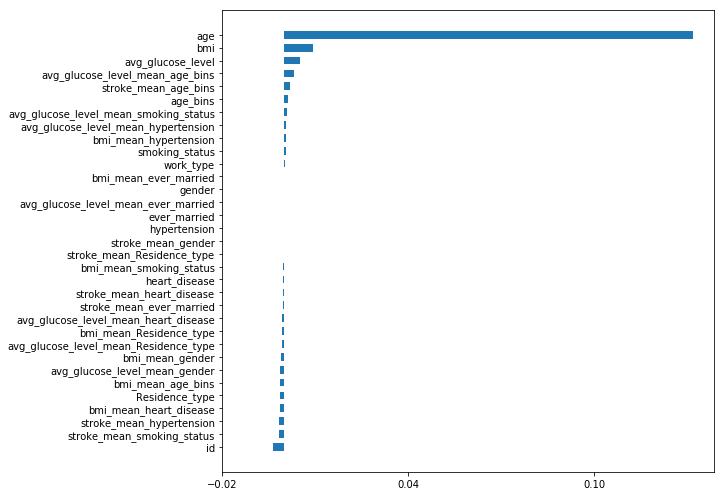

In [162]:
plot_importances(imp, figsize=(15,7))

#### Top features

In [163]:
imp.reset_index()

,Feature,Importance
0,id,-3.395085e-03
1,stroke_mean_smoking_status,-1.685959e-03
2,stroke_mean_hypertension,-1.463257e-03
3,bmi_mean_heart_disease,-1.301835e-03
4,Residence_type,-1.283152e-03
5,bmi_mean_age_bins,-1.275679e-03
6,avg_glucose_level_mean_gender,-1.262974e-03
7,bmi_mean_gender,-1.052230e-03
8,avg_glucose_level_mean_Residence_type,-6.740846e-04
9,bmi_mean_Residence_type,-6.666114e-04


In [164]:
select_cols = list(imp[imp.Importance>0].index)

In [165]:
select_cols

['avg_glucose_level_mean_ever_married',
 'gender',
 'bmi_mean_ever_married',
 'work_type',
 'smoking_status',
 'bmi_mean_hypertension',
 'avg_glucose_level_mean_hypertension',
 'avg_glucose_level_mean_smoking_status',
 'age_bins',
 'stroke_mean_age_bins',
 'avg_glucose_level_mean_age_bins',
 'avg_glucose_level',
 'bmi',
 'age']

#### RF after feature selection

In [166]:
clf = RandomForestClassifier(n_jobs=-1,
                             class_weight='balanced',
                             oob_score=True, 
                             bootstrap=True, 
                             n_estimators=100)

parameters = {'max_features': ['log2', 'sqrt','auto',0.5], 
              'min_samples_leaf': [1, 3, 5, 10,25,100, 150, 200], 
             }

grid_obj = GridSearchCV(clf, parameters, 
                        scoring='roc_auc',
                        verbose=20,
                        cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn2[select_cols],y_trn2),
                        iid = False) 

grid_obj = grid_obj.fit(x_trn2[select_cols], y_trn2)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] max_features=log2, min_samples_leaf=1 ...........................
[CV]  max_features=log2, min_samples_leaf=1, score=0.7459741338975832, total=   1.6s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.779432761401965, total=   1.5s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.791349464730899, total=   1.5s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.74848980788972, total=   1.6s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7701161630976827, total=   1.5s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8113976587359781, total=   1.7s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8457615486141663, total=   1.5s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8404710368089163, total=   1.6s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.3s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8068086229652442, total=   1.6s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.0s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8084681724845997, total=   1.4s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.822275295218542, total=   1.7s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   19.7s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8519958938260743, total=   1.7s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   21.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8426766388033435, total=   1.6s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   23.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8170142249596715, total=   1.5s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   25.1s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8265925491346435, total=   1.3s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8223980847166066, total=   1.4s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   28.2s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8636456958498314, total=   1.7s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   30.2s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8416113799677373, total=   1.6s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   32.0s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8250558732952045, total=   2.2s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   34.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.828787327662071, total=   1.9s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8362209233304702, total=   2.0s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.868614166300044, total=   1.6s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8539609913477049, total=   1.8s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8386091802317055, total=   1.7s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8390266940451745, total=   1.5s
[CV] max_features=log2, min_samples_leaf=100 .........................
[CV]  max_features=log2, min_samples_leaf=100, score=0.83701

[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8519354744097375, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8514175098988122, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8454420651217367, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8375337816604864, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.870900718580437, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8519114239624579, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=

[CV]  max_features=0.5, min_samples_leaf=3, score=0.8029694108664631, total=   1.9s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.830085349758029, total=   2.0s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8287836926235519, total=   1.9s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.7839313682358117, total=   2.0s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.7970266940451746, total=   2.1s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.8064953898653854, total=   2.1s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.847819328347265, to

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.6min finished


In [167]:
grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.76707, std: 0.01756, params: {'max_features': 'log2', 'min_samples_leaf': 1},
  mean: 0.82258, std: 0.01691, params: {'max_features': 'log2', 'min_samples_leaf': 3},
  mean: 0.83211, std: 0.01313, params: {'max_features': 'log2', 'min_samples_leaf': 5},
  mean: 0.83630, std: 0.01518, params: {'max_features': 'log2', 'min_samples_leaf': 10},
  mean: 0.84729, std: 0.01237, params: {'max_features': 'log2', 'min_samples_leaf': 25},
  mean: 0.85119, std: 0.01131, params: {'max_features': 'log2', 'min_samples_leaf': 100},
  mean: 0.85145, std: 0.01176, params: {'max_features': 'log2', 'min_samples_leaf': 150},
  mean: 0.85087, std: 0.01295, params: {'max_features': 'log2', 'min_samples_leaf': 200},
  mean: 0.76883, std: 0.01432, params: {'max_features': 'sqrt', 'min_samples_leaf': 1},
  mean: 0.81485, std: 0.01835, params: {'max_features': 'sqrt', 'min_samples_leaf': 3},
  mean: 0.82800, std: 0.01182, params: {'max_features': 'sqrt', 'min_samples_leaf': 5},
  mean: 0.83837, std: 0.

Similar hyperparamters and CV score after removing some features. It might have 

In [174]:
rf = grid_obj.best_estimator_
rf.fit(x_trn2[select_cols], y_trn2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [175]:
rf.oob_score_

0.782344470046083

In [179]:
# Validation score
roc_auc_score(y_val2, rf.predict_proba(x_val2[select_cols])[:,1])

0.83475361909438

In [176]:
imp = importances_perm(rf, x_val2[select_cols], y_val2, n_samples=len(y_val2)) # permutation

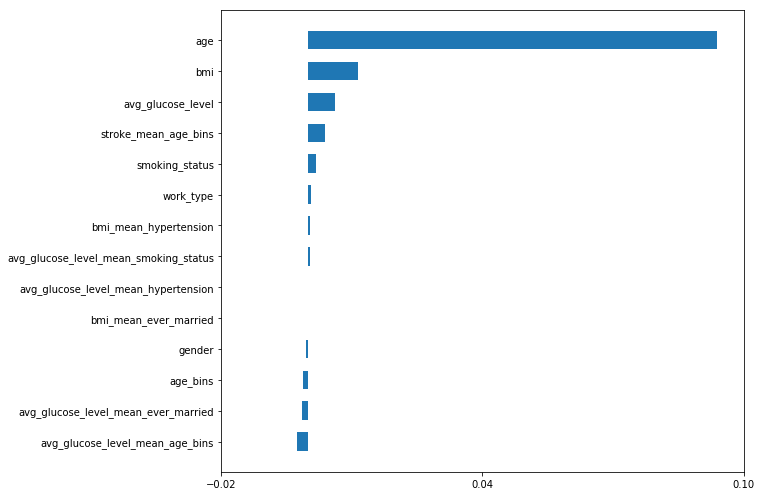

In [177]:
plot_importances(imp, figsize=(15,7))

#### Fitting on full data using same features

In [181]:
m = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
m.fit(train_enc[select_cols], train_enc['stroke'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [184]:
predictons = m.predict_proba(test_enc[select_cols])[:,1]
pred_df = pd.DataFrame(test.id)
pred_df['stroke'] = predictons
pred_df.to_csv('submissions/rf_tar_enc.csv', index=False)

### RF with only rfpimp and raw features

In [211]:
clf = RandomForestClassifier(n_jobs=-1,
                             class_weight='balanced',
                             oob_score=True, 
                             bootstrap=True, 
                             n_estimators=100)

parameters = {'max_features': ['log2', 'sqrt','auto',0.5], 
              'min_samples_leaf': [1, 3, 5, 10,25,100, 150, 200], 
             }

grid_obj = GridSearchCV(clf, parameters, 
                        scoring='roc_auc',
                        verbose=20,
                        cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn2[select_cols],y_trn2),
                        iid = False) 

#grid_obj = grid_obj.fit(x_trn2[select_cols], y_trn2)

In [212]:
x = train.drop(labels='stroke', axis=1)
y = train['stroke']

In [214]:
clf.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [216]:
imp = importances_perm(clf, x, y, n_samples=len(y)) # permutation

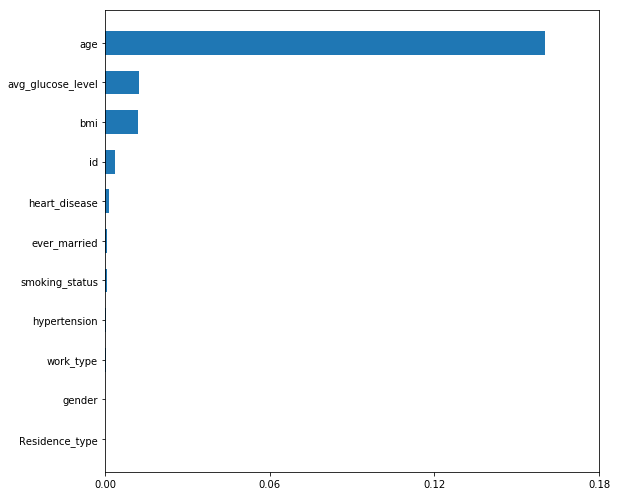

In [217]:
plot_importances(imp, figsize=(15,7))

In [220]:
imp

,Importance
Feature,
Residence_type,0.000080
gender,0.000106
work_type,0.000340
hypertension,0.000538
smoking_status,0.000670
ever_married,0.000674
heart_disease,0.001549
id,0.003708
bmi,0.012202


In [221]:
cols =list(imp[imp.Importance>0.001].index)

In [222]:
cols

['heart_disease', 'id', 'bmi', 'avg_glucose_level', 'age']

In [223]:
#Now doing grid search
grid_obj = grid_obj.fit(x[cols], y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] max_features=log2, min_samples_leaf=1 ...........................
[CV]  max_features=log2, min_samples_leaf=1, score=0.7453989609371171, total=   5.5s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7595481269430849, total=   2.0s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.772772699525224, total=   1.8s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7590283127582496, total=   1.8s
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=1, score=0.7550195473035433, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.2s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8100310003430867, total=   2.0s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8064234924739127, total=   1.6s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.2s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.800102312176072, total=   1.8s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.3s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.8189562416039016, total=   1.9s
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=3, score=0.7878320072833789, total=   1.8s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8198605392997762, total=   1.8s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   26.4s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8134047465139903, total=   1.8s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   28.5s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8105978801866406, total=   1.8s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   30.5s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.8203887512972171, total=   1.8s
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   32.5s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=5, score=0.816250107690624, total=   1.8s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   34.5s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8355148956852749, total=   1.9s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   36.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8320977621817958, total=   1.8s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   38.8s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.822744814183421, total=   1.6s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   40.6s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8410741912686943, total=   1.7s
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   42.7s remaining:    0.0s


[CV]  max_features=log2, min_samples_leaf=10, score=0.8160067850914265, total=   1.8s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8438709993628388, total=   1.6s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8455456028565274, total=   1.9s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8338982916767199, total=   1.8s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8533415676112742, total=   1.7s
[CV] max_features=log2, min_samples_leaf=25 ..........................
[CV]  max_features=log2, min_samples_leaf=25, score=0.8316184329093232, total=   1.6s
[CV] max_features=log2, min_samples_leaf=100 .........................
[CV]  max_features=log2, min_samples_leaf=100, score=0.846

[CV]  max_features=sqrt, min_samples_leaf=150, score=0.836614970011721, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8524515015884941, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=150 .........................
[CV]  max_features=sqrt, min_samples_leaf=150, score=0.8414130406942494, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8500378825009394, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8591608951272817, total=   1.7s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=0.8394133926111095, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=200 .........................
[CV]  max_features=sqrt, min_samples_leaf=200, score=

[CV]  max_features=0.5, min_samples_leaf=3, score=0.8102791256187816, total=   1.8s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8083904330963154, total=   1.7s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.7952049078201573, total=   2.1s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.8125010345903341, total=   1.6s
[CV] max_features=0.5, min_samples_leaf=3 ............................
[CV]  max_features=0.5, min_samples_leaf=3, score=0.7910854283525546, total=   1.7s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.8187148744465683, total=   1.9s
[CV] max_features=0.5, min_samples_leaf=5 ............................
[CV]  max_features=0.5, min_samples_leaf=5, score=0.8136202173176963, 

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  5.1min finished


In [224]:
grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

/Users/princegrover/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.75835, std: 0.00882, params: {'max_features': 'log2', 'min_samples_leaf': 1},
  mean: 0.80467, std: 0.01040, params: {'max_features': 'log2', 'min_samples_leaf': 3},
  mean: 0.81610, std: 0.00374, params: {'max_features': 'log2', 'min_samples_leaf': 5},
  mean: 0.82949, std: 0.00900, params: {'max_features': 'log2', 'min_samples_leaf': 10},
  mean: 0.84165, std: 0.00797, params: {'max_features': 'log2', 'min_samples_leaf': 25},
  mean: 0.84698, std: 0.00808, params: {'max_features': 'log2', 'min_samples_leaf': 100},
  mean: 0.84748, std: 0.00890, params: {'max_features': 'log2', 'min_samples_leaf': 150},
  mean: 0.84853, std: 0.00730, params: {'max_features': 'log2', 'min_samples_leaf': 200},
  mean: 0.75930, std: 0.01500, params: {'max_features': 'sqrt', 'min_samples_leaf': 1},
  mean: 0.80503, std: 0.01408, params: {'max_features': 'sqrt', 'min_samples_leaf': 3},
  mean: 0.81365, std: 0.01043, params: {'max_features': 'sqrt', 'min_samples_leaf': 5},
  mean: 0.83082, std: 0.

Predicting only on best estimaros

In [227]:
preds = grid_obj.best_estimator_.predict_proba(test[cols])[:,1]

(array([7452., 2342., 1686., 1373., 1282.,  979.,  728.,  878., 1414.,  467.]),
 array([0.     , 0.09023, 0.18045, 0.27068, 0.3609 , 0.45113, 0.54135, 0.63158, 0.72181, 0.81203, 0.90226]),
 <a list of 10 Patch objects>)

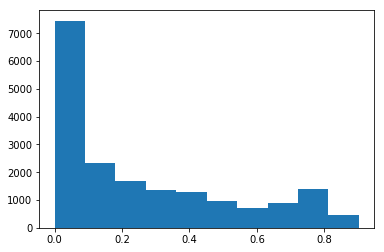

In [228]:
plt.hist(preds)

In [230]:
sum(preds>0.5)/len(preds)

0.2088059781732165

In [232]:
pred_df = pd.DataFrame(test.id)
pred_df['stroke'] = preds
pred_df.to_csv('submissions/rf_tuned_perm_imp_raw.csv', index=False)